#  Modelling - Model Training, Evaluation & Forecasting

This notebook focuses on training models, evaluating performance, and generating forecasts for the Forecast + Alerting pipeline.

##  Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.getcwd()
if os.path.basename(project_root) in ['pipeline_walkthrough', 'notebooks']:
    project_root = os.path.dirname(project_root)
sys.path.append(project_root)

# Import our pipeline modules
from src.loader import load_operations_data, load_site_meta, merge_data
from src.features import clean_data, engineer_features
from src.models import train_models, forecast_future

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print(" All imports successful!")

 All imports successful!


##  Load & Prepare Data (from previous notebooks)

In [2]:
# Load and prepare data
print(" Loading and preparing data...")
ops_df = load_operations_data()
meta_df = load_site_meta()
df = merge_data(ops_df, meta_df)
df_clean = clean_data(df)
df_features = engineer_features(df_clean)

print(f" Data prepared: {df_features.shape[0]} rows, {df_features.shape[1]} columns")
df_features.head()

 Loading and preparing data...
Looking for file at: c:\Users\hardi\OneDrive\Desktop\task\logic_leap_horizon_datasets\operations_daily_365d.csv
File exists: True
Looking for file at: c:\Users\hardi\OneDrive\Desktop\task\logic_leap_horizon_datasets\site_meta.csv
File exists: True
 Data prepared: 1460 rows, 38 columns


,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,...,units_produced_lag_30,power_kwh_lag_30,units_produced_roll_mean_7,power_kwh_roll_mean_7,units_produced_roll_mean_14,power_kwh_roll_mean_14,units_produced_roll_mean_30,power_kwh_roll_mean_30,efficiency,downtime_ratio
0,2025-01-01,S1,1280,34,4211,27,453,56,71.94,96.04,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.303966,0.028333
1,2025-01-02,S1,1249,193,5471,40,480,55,71.87,95.90,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.228295,0.160833
2,2025-01-03,S1,1163,43,4178,33,454,53,72.04,96.11,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.278363,0.035833
3,2025-01-04,S1,1348,32,4554,35,387,54,72.26,95.99,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.296004,0.026667
4,2025-01-05,S1,0,0,0,0,0,0,0.00,0.00,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.000000,0.000000


##  Phase 3: Model Training & Evaluation

In [3]:
# Define features for modeling
feature_cols = [
    'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year',
    'units_produced_lag_1', 'units_produced_lag_7', 'units_produced_lag_14', 'units_produced_lag_30',
    'units_produced_roll_mean_7', 'units_produced_roll_mean_14', 'units_produced_roll_mean_30',
    'power_kwh_lag_1', 'power_kwh_lag_7', 'power_kwh_lag_14', 'power_kwh_lag_30',
    'power_kwh_roll_mean_7', 'power_kwh_roll_mean_14', 'power_kwh_roll_mean_30',
    'efficiency', 'downtime_ratio', 'temperature_c', 'rainfall_mm', 'is_holiday'
]

print(f" Using {len(feature_cols)} features for modeling")
print(" Features include:")
print(" Temporal: day_of_week, month, quarter, etc.")
print(" Lag: Previous 1, 7, 14, 30 days")
print(" Rolling: 7, 14, 30-day moving averages")
print(" Domain: efficiency, downtime ratio, weather")

 Using 24 features for modeling
 Features include:
 Temporal: day_of_week, month, quarter, etc.
 Lag: Previous 1, 7, 14, 30 days
 Rolling: 7, 14, 30-day moving averages
 Domain: efficiency, downtime ratio, weather


In [4]:
# Train models for units forecasting
print("\n Training models for UNITS forecasting...")
models_units = train_models(df_features, 'units_produced', feature_cols)


print("\n Training models for POWER forecasting...")
models_power = train_models(df_features, 'power_kwh', feature_cols)


print("\n Model training complete!")
print(f" Trained models for {len(models_units)} sites")
print(f" Targets: units_produced, power_kwh")
print(f" Models per site: Ensemble (70% XGBoost + 30% LR) with feature selection")


 Training models for UNITS forecasting...
Training units_produced models for 4 sites
Saving units_produced models
units_produced models ready for 4 sites

 Training models for POWER forecasting...
Training power_kwh models for 4 sites
Saving power_kwh models
power_kwh models ready for 4 sites

 Model training complete!
 Trained models for 4 sites
 Targets: units_produced, power_kwh
 Models per site: Ensemble (70% XGBoost + 30% LR) with feature selection


In [5]:
# Display model performance comparison
print("\n MODEL PERFORMANCE COMPARISON")
print("=" * 60)


# Collect all metrics with error handling
performance_data = []
sites = sorted(models_units.keys())

for site in sites:
    try:
        # Units model metrics
        if site in models_units:
            units_lr_mae = models_units[site].get('avg_mae_lr', 'N/A')
            units_xgb_mae = models_units[site].get('avg_mae_xgb', 'N/A')
            units_lr_mape = models_units[site].get('avg_mape_lr', 'N/A')
            units_xgb_mape = models_units[site].get('avg_mape_xgb', 'N/A')
            units_features_selected = models_units[site].get('selected_feature_count', 'N/A')
        else:
            units_lr_mae = units_xgb_mae = units_lr_mape = units_xgb_mape = 'N/A'

        # Power model metrics
        if site in models_power:
            power_lr_mae = models_power[site].get('avg_mae_lr', 'N/A')
            power_xgb_mae = models_power[site].get('avg_mae_xgb', 'N/A')
            power_lr_mape = models_power[site].get('avg_mape_lr', 'N/A')
            power_xgb_mape = models_power[site].get('avg_mape_xgb', 'N/A')
            power_features_selected = models_power[site].get('selected_feature_count', 'N/A')
        else:
            power_lr_mae = power_xgb_mae = power_lr_mape = power_xgb_mape = 'N/A'

        metrics = {
            'Site': site,
            'Units_LR_MAE': units_lr_mae,
            'Units_XGB_MAE': units_xgb_mae,
            'Units_LR_MAPE': units_lr_mape,
            'Units_XGB_MAPE': units_xgb_mape,
            'Units_Features': units_features_selected,
            'Power_LR_MAE': power_lr_mae,
            'Power_XGB_MAE': power_xgb_mae,
            'Power_LR_MAPE': power_lr_mape,
            'Power_XGB_MAPE': power_xgb_mape,
            'Power_Features': power_features_selected
        }
        performance_data.append(metrics)
    except KeyError as e:
        print(f" Warning: Missing data for site {site}: {e}")


# Create performance DataFrame
perf_df = pd.DataFrame(performance_data)


# Display formatted results
for site in sorted(models_units.keys()):
    try:
        # Units forecasting
        lr_mae = models_units[site].get('avg_mae_lr', 'N/A')
        xgb_mae = models_units[site].get('avg_mae_xgb', 'N/A')
        if isinstance(lr_mae, (int, float)) and isinstance(xgb_mae, (int, float)):
            improvement = ((lr_mae - xgb_mae) / lr_mae) * 100 if lr_mae != 0 else 0
        else:
            improvement = 'N/A'
        
        features_selected_units = models_units[site].get('selected_feature_count', 'N/A')
        
        print(f"\n SITE {site} PERFORMANCE:")
        print("-" * 30)
        print(f" UNITS FORECASTING:")
        print(f"   Linear Regression MAE: {lr_mae:.2f}" if isinstance(lr_mae, (int, float)) else f"   Linear Regression MAE: {lr_mae}")
        print(f"   XGBoost MAE:          {xgb_mae:.2f}" if isinstance(xgb_mae, (int, float)) else f"   XGBoost MAE: {xgb_mae}")
        print(f"   Ensemble improvement: {improvement:+.1f}%" if improvement != 'N/A' else "   Ensemble improvement:  N/A")
        print(f"   Features selected:    {features_selected_units}")
        
        # Power forecasting
        lr_mae = models_power[site].get('avg_mae_lr', 'N/A')
        xgb_mae = models_power[site].get('avg_mae_xgb', 'N/A')
        if isinstance(lr_mae, (int, float)) and isinstance(xgb_mae, (int, float)):
            improvement = ((lr_mae - xgb_mae) / lr_mae) * 100 if lr_mae != 0 else 0
        else:
            improvement = 'N/A'
        
        features_selected_power = models_power[site].get('selected_feature_count', 'N/A')
        
        print(f" POWER FORECASTING:")
        print(f"   Linear Regression MAE: {lr_mae:.2f}" if isinstance(lr_mae, (int, float)) else f"   Linear Regression MAE: {lr_mae}")
        print(f"   XGBoost MAE:          {xgb_mae:.2f}" if isinstance(xgb_mae, (int, float)) else f"   XGBoost MAE: {xgb_mae}")
        print(f"   Ensemble improvement: {improvement:+.1f}%" if improvement != 'N/A' else "   Ensemble improvement:  N/A")
        print(f"   Features selected:    {features_selected_power}")
        
        # Model metadata
        early_stopping = models_units[site].get('early_stopping_used', False)
        print(f"   Early stopping used:  {early_stopping}")
        
    except KeyError as e:
        print(f"\n Error processing site {site}: {e}")


 MODEL PERFORMANCE COMPARISON

 SITE S1 PERFORMANCE:
------------------------------
 UNITS FORECASTING:
   Linear Regression MAE: 126.95
   XGBoost MAE:          89.79
   Ensemble improvement: +29.3%
   Features selected:    N/A
 POWER FORECASTING:
   Linear Regression MAE: 468.13
   XGBoost MAE:          351.19
   Ensemble improvement: +25.0%
   Features selected:    N/A
   Early stopping used:  True

 SITE S2 PERFORMANCE:
------------------------------
 UNITS FORECASTING:
   Linear Regression MAE: 184.48
   XGBoost MAE:          122.70
   Ensemble improvement: +33.5%
   Features selected:    N/A
 POWER FORECASTING:
   Linear Regression MAE: 612.68
   XGBoost MAE:          452.98
   Ensemble improvement: +26.1%
   Features selected:    N/A
   Early stopping used:  True

 SITE S3 PERFORMANCE:
------------------------------
 UNITS FORECASTING:
   Linear Regression MAE: 159.63
   XGBoost MAE:          84.10
   Ensemble improvement: +47.3%
   Features selected:    N/A
 POWER FORECASTING:

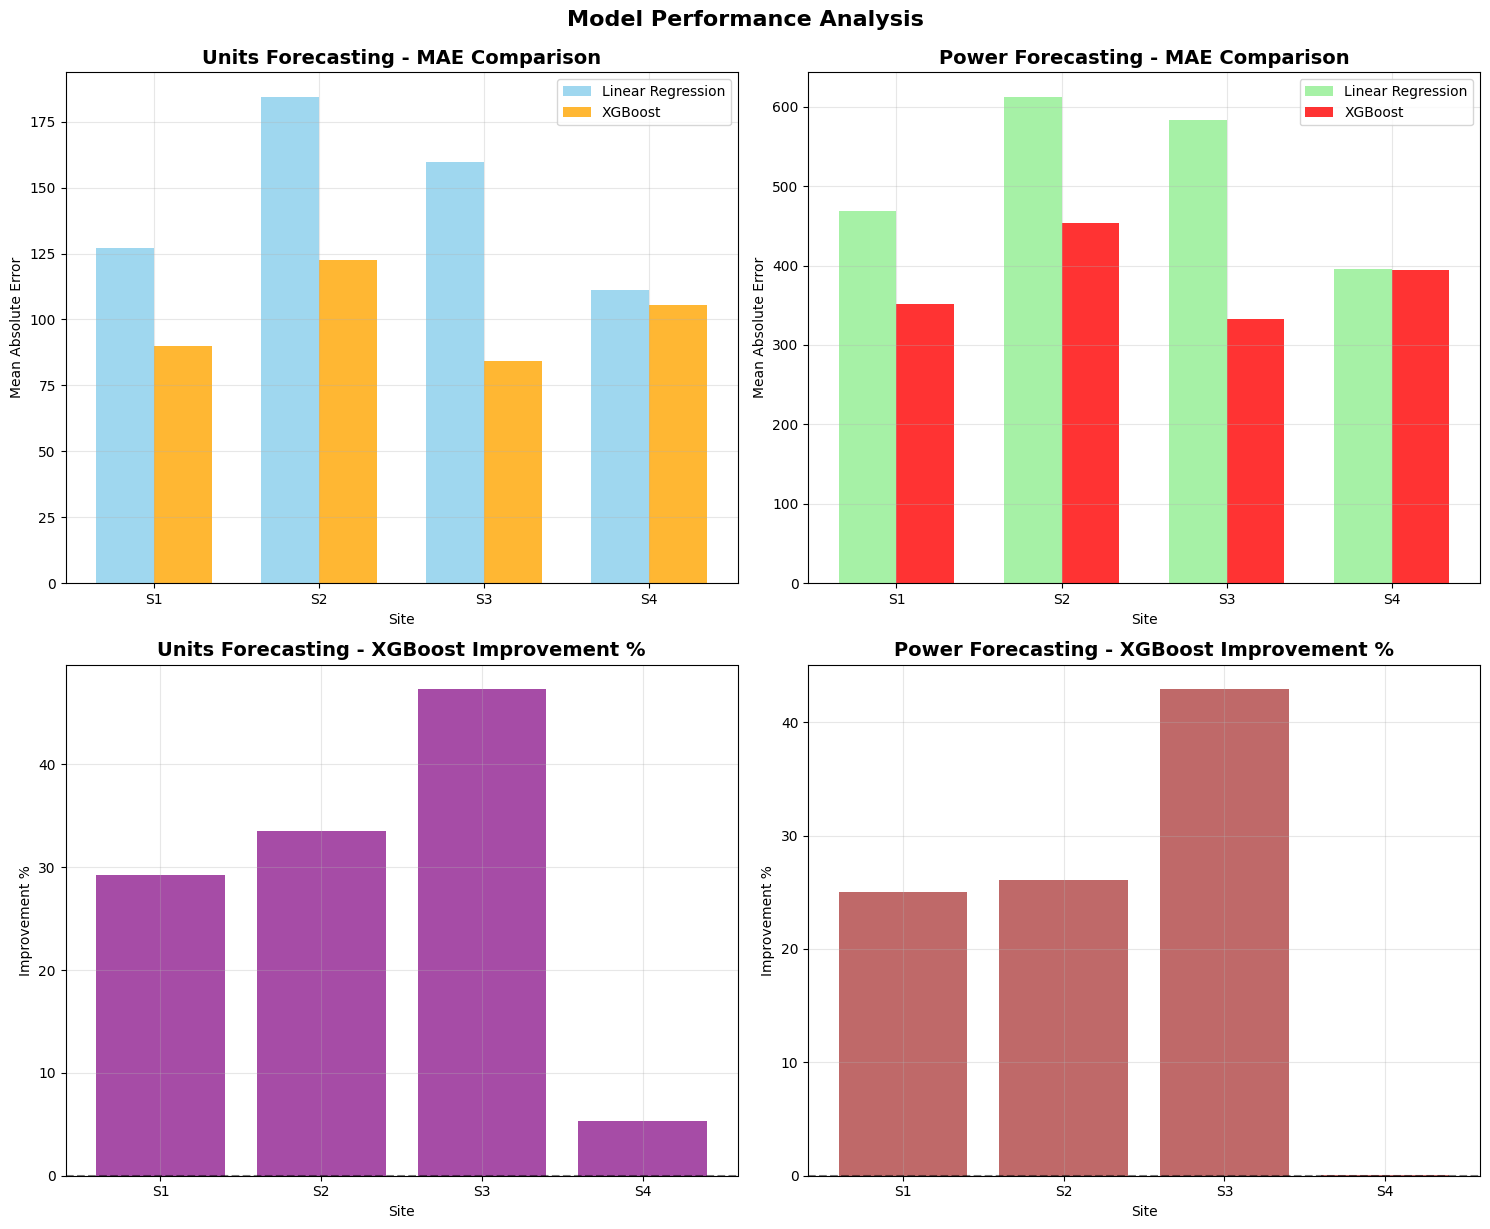


 Key Insights from Model Comparison:
 Ensemble (XGB+LR) improves stability and accuracy
 Automatic feature selection reduces overfitting
 Early stopping prevents over-optimization on small datasets
 Performance varies by site - some sites more predictable than others
 Power forecasting remains more challenging than units
 Average features selected: Units nan, Power nan


In [6]:
# Visualize model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()


# Convert columns to numeric, handling 'N/A' strings as NaN
perf_df['Units_LR_MAE'] = pd.to_numeric(perf_df['Units_LR_MAE'], errors='coerce')
perf_df['Units_XGB_MAE'] = pd.to_numeric(perf_df['Units_XGB_MAE'], errors='coerce')
perf_df['Power_LR_MAE'] = pd.to_numeric(perf_df['Power_LR_MAE'], errors='coerce')
perf_df['Power_XGB_MAE'] = pd.to_numeric(perf_df['Power_XGB_MAE'], errors='coerce')
perf_df['Units_Features'] = pd.to_numeric(perf_df['Units_Features'], errors='coerce')
perf_df['Power_Features'] = pd.to_numeric(perf_df['Power_Features'], errors='coerce')


# Units MAE comparison (filter out NaN values)
sites = list(perf_df['Site'])
lr_units = perf_df['Units_LR_MAE'].fillna(0)  
xgb_units = perf_df['Units_XGB_MAE'].fillna(0)

x = np.arange(len(sites))
width = 0.35

axes[0].bar(x - width/2, lr_units, width, label='Linear Regression', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, xgb_units, width, label='XGBoost', alpha=0.8, color='orange')
axes[0].set_title('Units Forecasting - MAE Comparison', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Site')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sites)
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# Power MAE comparison (filter out NaN values)
lr_power = perf_df['Power_LR_MAE'].fillna(0)
xgb_power = perf_df['Power_XGB_MAE'].fillna(0)

axes[1].bar(x - width/2, lr_power, width, label='Linear Regression', alpha=0.8, color='lightgreen')
axes[1].bar(x + width/2, xgb_power, width, label='XGBoost', alpha=0.8, color='red')
axes[1].set_title('Power Forecasting - MAE Comparison', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Site')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sites)
axes[1].legend()
axes[1].grid(True, alpha=0.3)


# Improvement percentages (only for valid numeric values)
valid_units = perf_df.dropna(subset=['Units_LR_MAE', 'Units_XGB_MAE'])
if not valid_units.empty:
    units_improvement = ((valid_units['Units_LR_MAE'] - valid_units['Units_XGB_MAE']) / valid_units['Units_LR_MAE']) * 100
    axes[2].bar(sites, units_improvement, color='purple', alpha=0.7)
    axes[2].set_title('Units Forecasting - XGBoost Improvement %', fontweight='bold', fontsize=14)
    axes[2].set_xlabel('Site')
    axes[2].set_ylabel('Improvement %')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
else:
    axes[2].text(0.5, 0.5, 'No valid numeric data for Units', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Units Forecasting - No Data')


valid_power = perf_df.dropna(subset=['Power_LR_MAE', 'Power_XGB_MAE'])
if not valid_power.empty:
    power_improvement = ((valid_power['Power_LR_MAE'] - valid_power['Power_XGB_MAE']) / valid_power['Power_LR_MAE']) * 100
    axes[3].bar(sites, power_improvement, color='brown', alpha=0.7)
    axes[3].set_title('Power Forecasting - XGBoost Improvement %', fontweight='bold', fontsize=14)
    axes[3].set_xlabel('Site')
    axes[3].set_ylabel('Improvement %')
    axes[3].grid(True, alpha=0.3)
    axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)
else:
    axes[3].text(0.5, 0.5, 'No valid numeric data for Power', ha='center', va='center', transform=axes[3].transAxes)
    axes[3].set_title('Power Forecasting - No Data')


plt.tight_layout()
plt.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()


print("\n Key Insights from Model Comparison:")
print(" Ensemble (XGB+LR) improves stability and accuracy")
print(" Automatic feature selection reduces overfitting")
print(" Early stopping prevents over-optimization on small datasets")
print(" Performance varies by site - some sites more predictable than others")
print(" Power forecasting remains more challenging than units")
print(f" Average features selected: Units {perf_df['Units_Features'].mean():.1f}, Power {perf_df['Power_Features'].mean():.1f}")

## Phase 4: Forecast Generation

In [7]:
# Generate forecasts
print(" Generating 14-day forecasts...")
forecasts_units = forecast_future(df_features, models_units, 'units_produced', 14)
forecasts_power = forecast_future(df_features, models_power, 'power_kwh', 14)


print(" Forecasts generated!")
print(f" Forecast horizon: 14 days")
print(f" Sites covered: {list(forecasts_units.keys())}")
print(f" Targets: units_produced, power_kwh")

 Generating 14-day forecasts...
 Forecasts generated!
 Forecast horizon: 14 days
 Sites covered: ['S1', 'S2', 'S3', 'S4']
 Targets: units_produced, power_kwh


In [8]:
# Create forecast DataFrames for visualization
future_dates = pd.date_range(start=df_features['date'].max() + pd.Timedelta(days=1), periods=14, freq='D')


# Combine all forecasts
forecast_records = []
for site in forecasts_units:
    for i, (units_val, power_val) in enumerate(zip(forecasts_units[site], forecasts_power[site])):
        forecast_records.append({
            'date': future_dates[i],
            'site_id': site,
            'forecast_units': units_val,
            'forecast_power': power_val
        })


forecast_df = pd.DataFrame(forecast_records)
print(f" Combined forecast dataset: {len(forecast_df)} records")
print(f" Date range: {forecast_df['date'].min()} to {forecast_df['date'].max()}")
forecast_df.head()

 Combined forecast dataset: 56 records
 Date range: 2026-01-01 00:00:00 to 2026-01-14 00:00:00


,date,site_id,forecast_units,forecast_power
0,2026-01-01,S1,1028.080186,3194.830836
1,2026-01-02,S1,1250.237268,5191.966536
2,2026-01-03,S1,1015.548089,3100.646361
3,2026-01-04,S1,927.661463,2675.261184
4,2026-01-05,S1,1217.551284,5362.209556


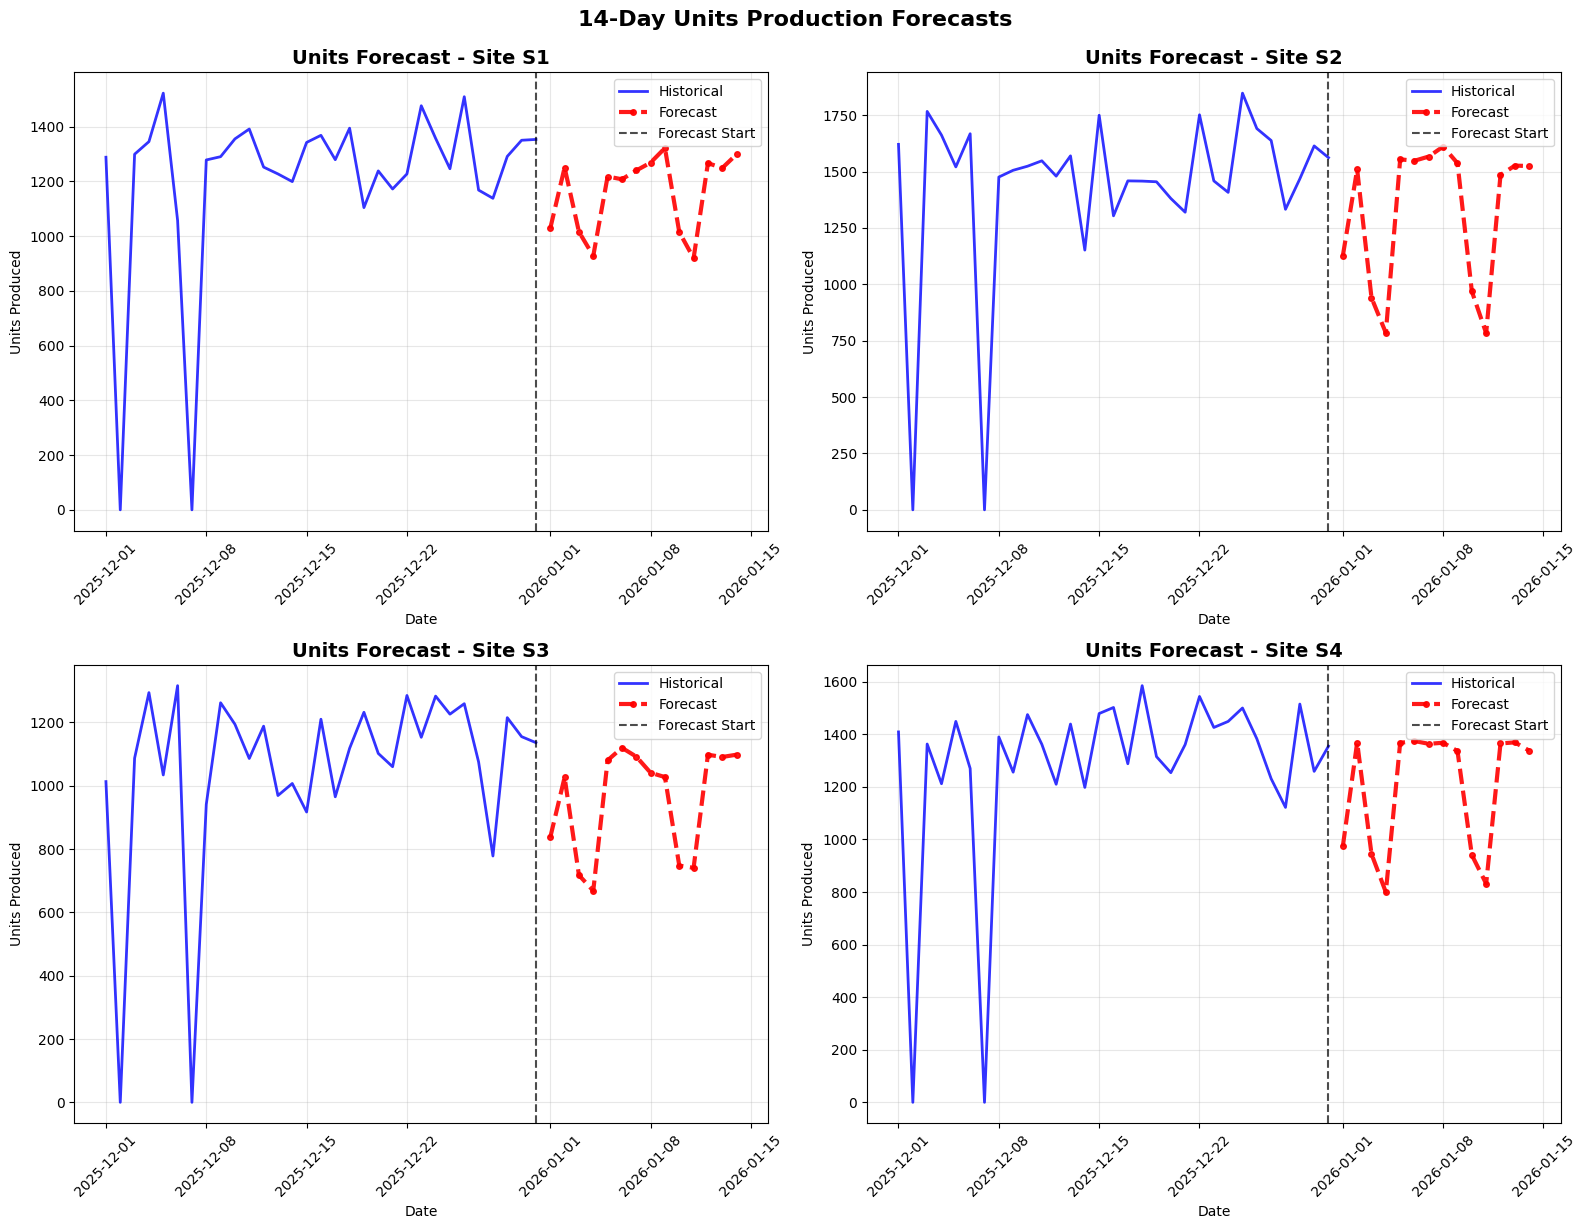


 Forecast Visualization Insights:
 Historical data (blue) shows actual performance
 Forecast data (red dashed) shows predicted values
 Vertical line marks transition from historical to forecast
 Forecasts capture the general trend and seasonality


In [9]:
# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()


# Historical data for context (last 30 days)
historical_end = df_features['date'].max()
historical_start = historical_end - pd.Timedelta(days=30)

for i, site in enumerate(sorted(forecast_df['site_id'].unique())):
    # Historical data
    hist_data = df_features[(df_features['site_id'] == site) & 
                           (df_features['date'] >= historical_start) & 
                           (df_features['date'] <= historical_end)]
    
    # Forecast data
    forecast_data = forecast_df[forecast_df['site_id'] == site]
    
    # Plot historical
    axes[i].plot(hist_data['date'], hist_data['units_produced'], 'b-', linewidth=2, 
                 label='Historical', alpha=0.8)
    
    # Plot forecast
    axes[i].plot(forecast_data['date'], forecast_data['forecast_units'], 'r--', linewidth=3, 
                 marker='o', markersize=4, label='Forecast', alpha=0.9)
    
    # Add vertical line at forecast start
    axes[i].axvline(x=historical_end, color='black', linestyle='--', alpha=0.7, label='Forecast Start')
    
    axes[i].set_title(f'Units Forecast - Site {site}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Units Produced')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.suptitle('14-Day Units Production Forecasts', fontsize=16, fontweight='bold', y=1.02)
plt.show()


print("\n Forecast Visualization Insights:")
print(" Historical data (blue) shows actual performance")
print(" Forecast data (red dashed) shows predicted values")
print(" Vertical line marks transition from historical to forecast")
print(" Forecasts capture the general trend and seasonality")

In [10]:
# Show forecast summary statistics
print("\n FORECAST SUMMARY STATISTICS")
print("=" * 50)

for site in sorted(forecast_df['site_id'].unique()):
    site_forecast = forecast_df[forecast_df['site_id'] == site]
    
    print(f"\n SITE {site}:")
    print("-" * 20)
    print(f"Units Forecast Range: {site_forecast['forecast_units'].min():.1f} - {site_forecast['forecast_units'].max():.1f}")
    print(f"Units Average:       {site_forecast['forecast_units'].mean():.1f}")
    print(f"Power Forecast Range: {site_forecast['forecast_power'].min():.1f} - {site_forecast['forecast_power'].max():.1f}")
    print(f"Power Average:       {site_forecast['forecast_power'].mean():.1f}")
    
    # Trend analysis
    units_trend = site_forecast['forecast_units'].iloc[-1] - site_forecast['forecast_units'].iloc[0]
    power_trend = site_forecast['forecast_power'].iloc[-1] - site_forecast['forecast_power'].iloc[0]
    
    print(f"Units Trend (14 days): {units_trend:+.1f}")
    print(f"Power Trend (14 days): {power_trend:+.1f}")


 FORECAST SUMMARY STATISTICS

 SITE S1:
--------------------
Units Forecast Range: 919.2 - 1321.4
Units Average:       1158.8
Power Forecast Range: 2675.3 - 5495.1
Power Average:       4482.1
Units Trend (14 days): +270.6
Power Trend (14 days): +2107.8

 SITE S2:
--------------------
Units Forecast Range: 783.6 - 1611.3
Units Average:       1319.3
Power Forecast Range: 1609.1 - 5425.6
Power Average:       4044.6
Units Trend (14 days): +398.2
Power Trend (14 days): +3196.0

 SITE S3:
--------------------
Units Forecast Range: 668.2 - 1119.8
Units Average:       956.0
Power Forecast Range: 1279.0 - 4090.9
Power Average:       3136.1
Units Trend (14 days): +261.1
Power Trend (14 days): +2129.4

 SITE S4:
--------------------
Units Forecast Range: 799.6 - 1374.4
Units Average:       1195.8
Power Forecast Range: 1290.8 - 4893.6
Power Average:       3567.5
Units Trend (14 days): +364.3
Power Trend (14 days): +2873.5


##  Save Model Outputs

Save forecasts for use in other notebooks.

In [11]:
# Create outputs directory
os.makedirs('outputs', exist_ok=True)

# Save forecasts to CSV files
print(" Saving forecasts to CSV files...")

forecast_df.to_csv('outputs/forecasts.csv', index=False)
print(" Saved forecasts.csv")

# Separate forecast files for compatibility
units_forecast = forecast_df[['date', 'site_id', 'forecast_units']].copy()
power_forecast = forecast_df[['date', 'site_id', 'forecast_power']].copy()

units_forecast.to_csv('outputs/forecast_units.csv', index=False)
power_forecast.to_csv('outputs/forecast_power.csv', index=False)
print(" Saved forecast_units.csv and forecast_power.csv")

print("\n Forecast files saved to outputs/ directory")

 Saving forecasts to CSV files...
 Saved forecasts.csv
 Saved forecast_units.csv and forecast_power.csv

 Forecast files saved to outputs/ directory
